In [1]:
%matplotlib inline

In [2]:
import  os
import  sys
import  glob
import  pdfkit
import  fitsio
import  redrock
import  datetime
import  redrock.templates
import  fitsio 

import  healpy 
import  requests
import  pandas                      as      pd
import  pylab                       as      pl
import  numpy                       as      np
import  matplotlib.pyplot           as      plt
import  astropy.io.fits             as      fits

from    astropy.table               import  Table, join, vstack, unique
from    astropy.coordinates         import  SkyCoord
from    astropy                     import  units as u
from    desitarget.cmx              import  cmx_targetmask
from    desitarget.targets          import  desi_mask, bgs_mask, mws_mask
from    desispec.interpolation      import  resample_flux
from    desispec.resolution         import  Resolution
from    desispec.specscore          import  compute_frame_scores
from    collections                 import  OrderedDict
from    mpl_toolkits.axes_grid1     import  make_axes_locatable
from    itertools                   import  combinations
from    desisurvey.utils            import  get_date
from    PIL                         import  Image
from    io                          import  BytesIO
from    desitarget.sv1              import  sv1_cuts 
from    desiutil                    import  dust

##  Night log.
http://desi-www.kpno.noao.edu:8090/nightsum/nightsum-2020-02-25/nightsum.html

##  Mini SV page.
https://desi.lbl.gov/trac/wiki/TargetSelectionWG/miniSV2

In [3]:
root          = '/global/cfs/cdirs/desi/spectro/redux/minisv2/tiles/'

In [4]:
night_tiles   = [('20200225', 70502),
                 ('20200227', 70502),
                 ('20200228', 70500),
                 ('20200303', 70500)]

In [5]:
sample        = Table()
row           = Table()

In [6]:
plot          = False

acoadds       = Table()
azbests       = Table()
acoadds_paths = []

for night, tile in night_tiles:
  for petal in [0,3,6,7,9]: 
    specfile                  = root + '{}/{}/coadd-{}-{}-{}.fits'.format(tile, night, petal, tile, night)

    coadds                    = Table(fits.open(specfile)[1].data)
    zbest                     = Table(fits.open(root + '/{}/{}/zbest-{}-{}-{}.fits'.format(tile, night, petal, tile, night))[1].data)
    
    acoadds_paths.append(specfile)
    
    targetids                 = zbest['TARGETID']
    fibstatus                 = fitsio.read(specfile, ext=1)['FIBERSTATUS']
    
    # No fiber reach flags available.
    isgood                    = fibstatus == 0
            
    IS_SV0                    = (coadds['CMX_TARGET'] & cmx_targetmask.cmx_mask.mask('SV0_BGS')) != 0

    IS_GOOD_BGS               = IS_SV0 & isgood
    IS_MAIN                   = IS_GOOD_BGS & ((coadds['CMX_TARGET'] & cmx_targetmask.cmx_mask.mask('MINI_SV_BGS_BRIGHT')) != 0)
    
    # Exclude QSOs (lack of redshift precision for small scales).
    IS_ZGOOD_BGS              = IS_GOOD_BGS  & (zbest['ZWARN'] == 0) & (zbest['SPECTYPE'] == 'GALAXY') 
    IS_ZGOOD_BGS              = IS_ZGOOD_BGS & (zbest['ZERR'] < 0.0005 * (1. + zbest['Z']))
    
    IS_ZGOOD_MAIN             = IS_ZGOOD_BGS & ((coadds['CMX_TARGET'] & cmx_targetmask.cmx_mask.mask('MINI_SV_BGS_BRIGHT')) != 0)

    coadds['NIGHT']           = [night] * len(coadds)
    coadds['TILEID']          = [tile] * len(coadds)
    
    zbest['NIGHT']            = [night] * len(coadds)
    zbest['TILEID']           = [tile] * len(coadds)

    acoadds                   = vstack((acoadds, coadds[IS_ZGOOD_BGS]))
    azbests                   = vstack((azbests,  zbest[IS_ZGOOD_BGS]))

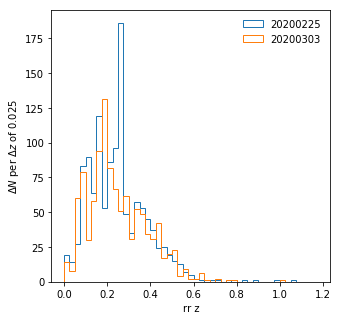

In [7]:
fig, axes   = plt.subplots(1, figsize=(5, 5))

nights = list(np.unique(azbests['NIGHT']))

nights.remove('20200227')
nights.remove('20200228')

for night in nights:  
  _ = pl.hist(azbests['Z'][azbests['NIGHT'] == night], bins=np.arange(0.0, 1.2, 0.025), histtype='step', label=night)

pl.xlabel('rr z')
pl.ylabel(r'$\Delta N$ per $\Delta z$ of {}'.format(0.025))

pl.legend(frameon=False, loc=1)

In [9]:
acoadds.sort('FLUX_R')

In [10]:
acoadds

TARGETID,PETAL_LOC,DEVICE_LOC,LOCATION,FIBER,FIBERSTATUS,TARGET_RA,TARGET_DEC,PMRA,PMDEC,PMRA_IVAR,PMDEC_IVAR,REF_EPOCH,LAMBDA_REF,FA_TARGET,FA_TYPE,OBJTYPE,FIBERASSIGN_X,FIBERASSIGN_Y,NUMTARGET,PRIORITY,SUBPRIORITY,OBSCONDITIONS,NUMOBS_MORE,RELEASE,BRICKID,BRICKNAME,BRICK_OBJID,MORPHTYPE,TARGET_RA_IVAR,TARGET_DEC_IVAR,EBV,FLUX_G,FLUX_R,FLUX_Z,FLUX_IVAR_G,FLUX_IVAR_R,FLUX_IVAR_Z,MW_TRANSMISSION_G,MW_TRANSMISSION_R,MW_TRANSMISSION_Z,FRACFLUX_G,FRACFLUX_R,FRACFLUX_Z,FRACMASKED_G,FRACMASKED_R,FRACMASKED_Z,FRACIN_G,FRACIN_R,FRACIN_Z,NOBS_G,NOBS_R,NOBS_Z,PSFDEPTH_G,PSFDEPTH_R,PSFDEPTH_Z,GALDEPTH_G,GALDEPTH_R,GALDEPTH_Z,FLUX_W1,FLUX_W2,FLUX_W3,FLUX_W4,FLUX_IVAR_W1,FLUX_IVAR_W2,FLUX_IVAR_W3,FLUX_IVAR_W4,MW_TRANSMISSION_W1,MW_TRANSMISSION_W2,MW_TRANSMISSION_W3,MW_TRANSMISSION_W4,ALLMASK_G,ALLMASK_R,ALLMASK_Z,FIBERFLUX_G,FIBERFLUX_R,FIBERFLUX_Z,FIBERTOTFLUX_G,FIBERTOTFLUX_R,FIBERTOTFLUX_Z,WISEMASK_W1,WISEMASK_W2,MASKBITS,FRACDEV,FRACDEV_IVAR,SHAPEDEV_R,SHAPEDEV_E1,SHAPEDEV_E2,SHAPEDEV_R_IVAR,SHAPEDEV_E1_IVAR,SHAPEDEV_E2_IVAR,SHAPEEXP_R,SHAPEEXP_E1,SHAPEEXP_E2,SHAPEEXP_R_IVAR,SHAPEEXP_E1_IVAR,SHAPEEXP_E2_IVAR,REF_ID,REF_CAT,GAIA_PHOT_G_MEAN_MAG,GAIA_PHOT_G_MEAN_FLUX_OVER_ERROR,GAIA_PHOT_BP_MEAN_MAG,GAIA_PHOT_BP_MEAN_FLUX_OVER_ERROR,GAIA_PHOT_RP_MEAN_MAG,GAIA_PHOT_RP_MEAN_FLUX_OVER_ERROR,GAIA_PHOT_BP_RP_EXCESS_FACTOR,GAIA_ASTROMETRIC_EXCESS_NOISE,GAIA_DUPLICATED_SOURCE,GAIA_ASTROMETRIC_SIGMA5D_MAX,GAIA_ASTROMETRIC_PARAMS_SOLVED,PARALLAX,PARALLAX_IVAR,PHOTSYS,CMX_TARGET,PRIORITY_INIT,NUMOBS_INIT,HPXPIXEL,BLOBDIST,FIBERFLUX_IVAR_G,FIBERFLUX_IVAR_R,FIBERFLUX_IVAR_Z,DESI_TARGET,BGS_TARGET,MWS_TARGET,NUM_ITER,FIBER_X,FIBER_Y,MEAN_DELTA_X,MEAN_DELTA_Y,FIBER_RA,FIBER_DEC,COADD_NUMEXP,RMS_DELTA_X,RMS_DELTA_Y,FIRST_FIBER,LAST_FIBER,NUM_FIBER,NIGHT,TILEID
int64,int16,int32,int64,int32,int32,float64,float64,float32,float32,float32,float32,float32,float32,int64,uint8,str3,float32,float32,int16,int32,float64,int32,int32,int16,int32,str8,int32,str4,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,int16,int16,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,int16,int16,float32,float32,float32,float32,float32,float32,uint8,uint8,int16,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int64,str2,float32,float32,float32,float32,float32,float32,float32,float32,bool,float32,bool,float32,float32,str1,int64,int64,int64,int64,float32,float32,float32,float32,int64,int64,int64,int64,float64,float64,float64,float64,float64,float64,int16,float64,float64,int64,int64,int64,str8,int64
35191208644970149,9,171,9171,4980,0,119.80239916760004,49.237255747930206,0.0,0.0,0.0,0.0,0.0,5400.0,256,1,TGT,-128.6238,-187.7574,0,1000,0.7866496143793505,65535,99,8001,581386,1199p492,1701,PSF,263610730000.0,275361370000.0,0.04009547,2.4870965,4.558965,5.652372,508.3076,203.34673,104.589066,0.8880824,0.92316073,0.9562639,0.0,0.0,0.0,0.010838491,0.010178695,0.011021298,0.99537796,0.99648243,0.9953619,3,3,2,667.0352,259.1892,117.088684,463.9592,177.81886,59.45564,0.997754,0.45951456,49.446938,-278.5507,3.009242,0.621018,0.0010093496,1.2574406e-05,0.993228,0.99583566,0.9991104,0.999664,0,0,0,1.9333891,3.543993,4.3939724,1.9333891,3.543993,4.3939724,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True,0.0,True,0.0,0.0,N,256,2100,1,6631,0.0,0.0,0.0,0.0,0,0,0,3,-128.53,-187.663,-0.0015000000000000002,0.001666666666666667,0.0,0.0,12,0.002798809270624444,0.004830458915396479,4980,4980,1,20200303,70500
35191232053380231,6,311,6311,3119,0,120.48675554769679,50.73729174109678,0.0,0.0,0.0,0.0,0.0,5400.0,256,1,TGT,-234.85448,185.24544,0,1000,0.9915608450147327,65535,99,8001,586967,1203p507,1159,PSF,208334980000.0,220169030000.0,0.040291186,3.9069219,4.8613734,2.8339

##  Done.